# Import modules, libraries, and packages

In [20]:
%load_ext autoreload
%autoreload 2

import os
import sys

# Get the current working directory of the notebook
CURRENT_DIR = os.getcwd()
# Add the parent directory of the notebook to the Python path
ROOT_DIR = os.path.abspath(os.path.join(CURRENT_DIR, '..', '..', '..'))
sys.path.append(ROOT_DIR)

import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import geopandas as gpd
from fiona.crs import from_epsg

from utils.utils import load_util_data, get_unusable_basins

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Parameters and constants

In [2]:
data_dir, data_gen = load_util_data(CURRENT_DIR)

BASINS_DIR = data_dir['data_dir_camels_spat_nh']
DATASET = data_dir['data_dir_camels_spat_nh'].split('/')[-1]
INPUT_FILES_DIR = data_dir['data_dir_camels_spat_nh']
BASIN_SET_FILES_DIR = os.path.join(INPUT_FILES_DIR, 'merged_lumped_shapes')

COUNTRIES = data_gen['countries']

## Load unusable basins

In [3]:
unusuable_basins = get_unusable_basins(INPUT_FILES_DIR, data_gen['camels_spat_unusable'])

## Loading basin IDs

In [4]:
##Read the basin shapefile
gdf_basins = gpd.read_file(os.path.join(BASIN_SET_FILES_DIR, 'merged_lumped_outlines.shp'))
# Subset the basins to only include the ones that are usable
gdf_basins = gdf_basins[~gdf_basins['Station_id'].isin(unusuable_basins)]

# # merged_lumped_outlines
# camels_new_delineation = gpd.read_file(os.path.join(BASIN_SET_FILES_DIR, 'camels_new_delineation.shp'))

gdf_borders = gpd.read_file(os.path.join(INPUT_FILES_DIR, 'NA_PoliticalDivision/boundaries_p_2021_v3.shp'))
states = gpd.read_file(os.path.join(BASIN_SET_FILES_DIR, 'USA_Canada_ShapefileMerge.shp'))

In [5]:
gdf_basins.value_counts('Country')

Country
CAN    764
USA    662
Name: count, dtype: int64

In [6]:
# Set the CRS for gdf_basins
gdf_basins.crs = from_epsg(4326)

# Set a common CRS for both GeoDataFrames
common_crs = 'ESRI:102008'
gdf_basins = gdf_basins.to_crs(common_crs)

gdf_borders = gdf_borders.to_crs(common_crs)
gdf_borders = gdf_borders.set_crs(common_crs, allow_override=True)

## Load time_stats df

In [8]:
# Load the DataFrame from the CSV file
file_path = os.path.join(BASINS_DIR, f'camels_spat_1426_dates_stats.csv')
all_time_stats_df = pd.read_csv(file_path)

In [9]:
set(all_time_stats_df['Start_decade']), set (all_time_stats_df['End_decade'])

({1950, 1960, 1970, 1980, 1990}, {2000, 2010})

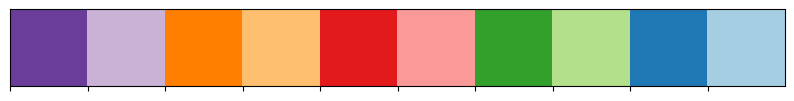

In [10]:
# Get unique start and end decades
start_decades = sorted(set(all_time_stats_df['Start_decade']))
end_decades = sorted(set(all_time_stats_df['End_decade']))

# Generate a color palette using seaborn's Paired palette
palette = sns.color_palette("Paired", len(start_decades) * len(end_decades))

# Reverse the palette
reversed_palette = palette[::-1]

# Plot the reversed palette
sns.palplot(reversed_palette)

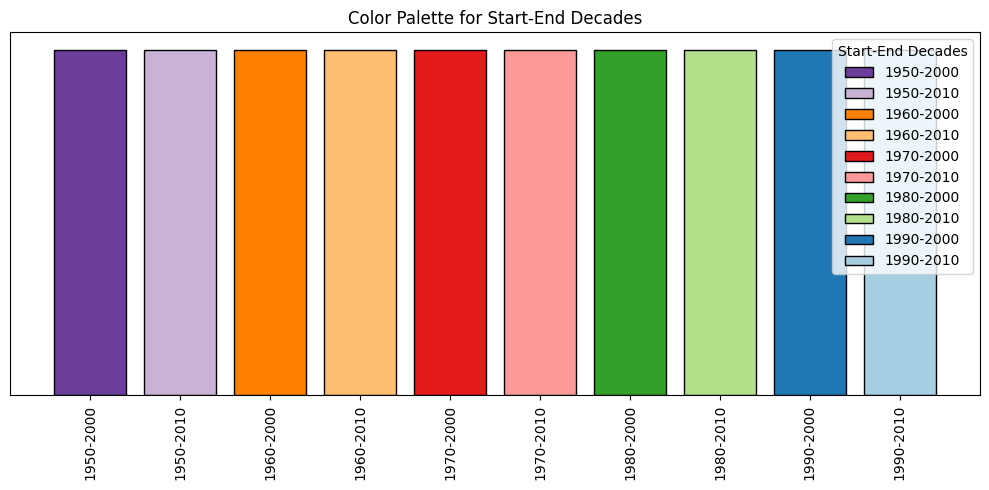

In [11]:
# Get unique start and end decades
start_decades = sorted(set(all_time_stats_df['Start_decade']))
end_decades = sorted(set(all_time_stats_df['End_decade']))

# Generate a list of pairs of start and end decades
decade_pairs = [(start, end) for start in start_decades for end in end_decades]

# Reverse the palette
reversed_palette = sns.color_palette("Paired", len(decade_pairs))[::-1]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the pairs of start and end decades
for i, (start, end) in enumerate(decade_pairs):
    ax.bar(i, 1, color=reversed_palette[i], label=f'{start}-{end}', edgecolor='k')

# Customize the plot
ax.set_xticks(range(len(decade_pairs)))
ax.set_xticklabels([f'{start}-{end}' for start, end in decade_pairs], rotation=90)
ax.set_yticks([])
ax.legend(title='Start-End Decades', loc='upper right')
ax.set_title('Color Palette for Start-End Decades')

# Show the plot
plt.tight_layout()
plt.show()

1950-2000: 1 basins
1950-2010: 545 basins
1960-2010: 368 basins
1970-2000: 1 basins
1970-2010: 261 basins
1980-2010: 215 basins
1990-2010: 35 basins
Total number of colors: 7
Decade pairs: [(1950, 2000), (1950, 2010), (1960, 2010), (1970, 2000), (1970, 2010), (1980, 2010), (1990, 2010)]


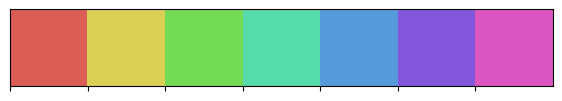

In [36]:
## How many basins per start-end decade combination? (Number of basins per color)
tot_colors = 0
decade_pairs = []
for (start_decade, end_decade), group in all_time_stats_df.groupby(['Start_decade', 'End_decade']):
    # Select the basins from gdf_basins based on the group indices
    basins_subset = gdf_basins.iloc[group.index]
    print(f'{start_decade}-{end_decade}: {len(basins_subset)} basins')
    tot_colors += 1
    decade_pairs.append((start_decade, end_decade))
print(f'Total number of colors: {tot_colors}')
print(f'Decade pairs: {decade_pairs}')

# Create a map color of tot_colors colors
colors_map = sns.color_palette("hls", tot_colors)
# Plot the colors
sns.palplot(colors_map)

In [37]:
# Define color map for start-end decade combinations
decade_cmap = {}
colors_cmap = {}
for i, start_decade in enumerate(start_decades):
    for j, end_decade in enumerate(end_decades):
        decade_cmap[(start_decade, end_decade)] = reversed_palette[i * len(end_decades) + j]
        
for i in range(tot_colors):
    colors_cmap[(decade_pairs[i][0], decade_pairs[i][1])] = colors_map[i]
        
decade_cmap, colors_cmap

({(1950, 2000): (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
  (1950, 2010): (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
  (1960, 2000): (1.0, 0.4980392156862745, 0.0),
  (1960, 2010): (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
  (1970, 2000): (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
  (1970, 2010): (0.984313725490196, 0.6039215686274509, 0.6),
  (1980, 2000): (0.2, 0.6274509803921569, 0.17254901960784313),
  (1980, 2010): (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
  (1990, 2000): (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
  (1990, 2010): (0.6509803921568628, 0.807843137254902, 0.8901960784313725)},
 {(1950, 2000): (0.86, 0.3712, 0.33999999999999997),
  (1950, 2010): (0.86, 0.8169142857142857, 0.33999999999999997),
  (1960, 2010): (0.4573714285714283, 0.86, 0.33999999999999997),
  (1970, 2000): (0.33999999999999997, 0.86, 0.6683428571428571),
  (1970, 2010): (0.3399999

In [14]:
gdf_basins.head()

,Country,Station_id,Station_na,Delineatio,Delineat_1,geometry
1,CAN,01AD003,ST. FRANCIS RIVER AT OUTLET OF GLASIER LAKE,high,None,"MULTIPOLYGON (((1898852.197 1123651.860, 18987..."
3,CAN,01AF007,GRANDE RIVIERE AT VIOLETTE BRIDGE,high,None,"POLYGON ((1983771.377 1179001.391, 1983827.996..."
4,CAN,01AF009,IROQUOIS RIVER AT MOULIN MORNEAULT,high,None,"POLYGON ((1927406.008 1190627.995, 1927745.105..."
5,CAN,01AJ003,MEDUXNEKEAG RIVER NEAR BELLEVILLE,high,None,"MULTIPOLYGON (((1997842.610 1060414.910, 19977..."
6,CAN,01AJ004,BIG PRESQUE ISLE STREAM AT TRACEY MILLS,high,None,"POLYGON ((1992659.670 1091435.721, 1992774.447..."


In [15]:
all_time_stats_df.head()

,Country,Station_id,Start_date,End_date,Total_years,Start_decade,End_decade
0,CAN,01AD003,1951-10-01,2019-12-31,68.3,1950,2010
1,CAN,01AF007,1977-01-01,2019-12-31,43.0,1970,2010
2,CAN,01AF009,1991-01-01,2019-12-31,29.0,1990,2010
3,CAN,01AJ003,1967-12-01,2019-12-31,52.1,1960,2010
4,CAN,01AJ004,1967-11-01,2019-12-31,52.2,1960,2010


In [31]:
decade_cmap

{(1950, 2000): (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1950, 2010): (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (1960, 2000): (1.0, 0.4980392156862745, 0.0),
 (1960, 2010): (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1970, 2000): (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (1970, 2010): (0.984313725490196, 0.6039215686274509, 0.6),
 (1980, 2000): (0.2, 0.6274509803921569, 0.17254901960784313),
 (1980, 2010): (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (1990, 2000): (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (1990, 2010): (0.6509803921568628, 0.807843137254902, 0.8901960784313725)}

In [32]:
colors_map

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.8169142857142857, 0.33999999999999997),
 (0.4573714285714283, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.6683428571428571),
 (0.33999999999999997, 0.6059428571428571, 0.86),
 (0.5197714285714281, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.7545142857142858)]

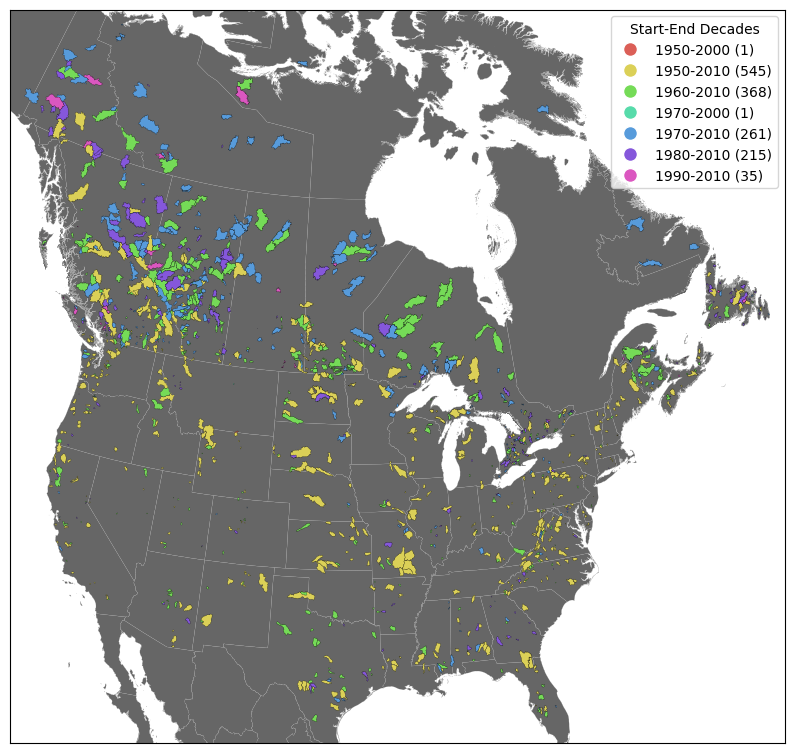

In [38]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the reprojected gdf_borders
gdf_borders.plot(ax=ax, facecolor='0.4', edgecolor='0.7', linewidth=0.1)

# Plot the basins with different colors based on start-end decade combination
legend_handles = []  # To store legend handles
for (start_decade, end_decade), group in all_time_stats_df.groupby(['Start_decade', 'End_decade']):
    basin_color = decade_cmap.get((start_decade, end_decade), 'black')
    # basin_color = colors_cmap.get((start_decade, end_decade), 'black')
    # Select the basins from gdf_basins based on the group indices
    basins_subset = gdf_basins.iloc[group.index]
    # Plot the basins together and append the legend handle
    basins_subset.plot(ax=ax, color=basin_color, edgecolor='k', linewidth=0.1, 
                       label=f'{start_decade}-{end_decade} ({len(basins_subset)})')

    # Create a dummy artist for legend
    legend_handles.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=basin_color, markersize=10, 
                                 label=f'{start_decade}-{end_decade} ({len(basins_subset)})'))

# Chart junk
ax.set_xlim([-2.5*1e6, 3.1*1e6])
ax.set_ylim([-1.6*1e6, 3.7*1e6])
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])

# Add custom legend
ax.legend(handles=legend_handles, title='Start-End Decades', loc='upper right')

# Show the plot
plt.show()

In [19]:
legend_handles

[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]

In [17]:
a = 23 = 45.fff

SyntaxError: invalid syntax (3210590870.py, line 1)

# Catchments plots

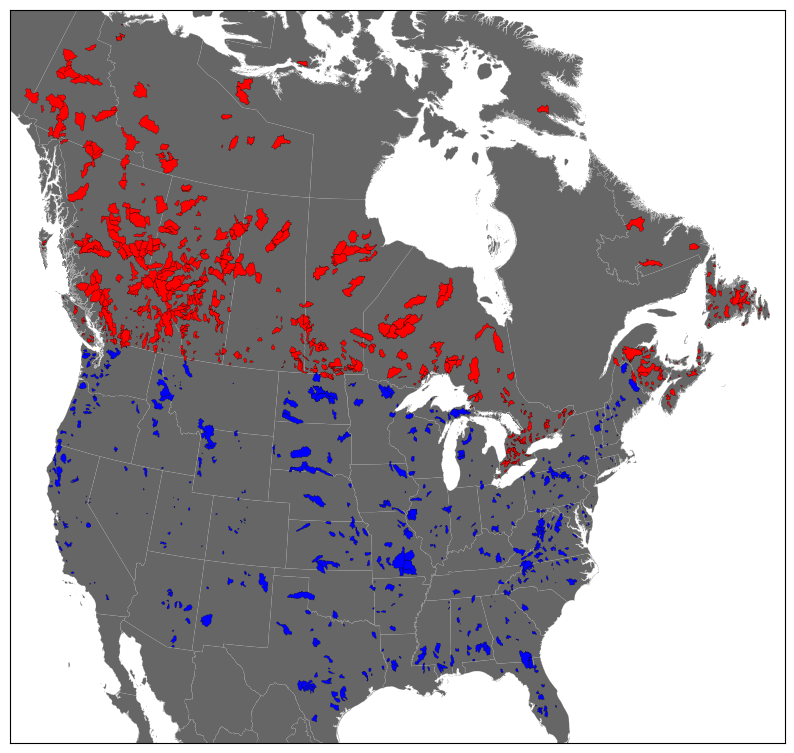

In [ ]:
# Map color for country (CAN, USA)
cmap = {'CAN': 'r', 'USA': 'b'}

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the reprojected gdf_borders
# gdf_borders.boundary.plot(ax=ax, color=None, edgecolor='k', linewidth=0.1)
gdf_borders.plot(ax=ax, facecolor='0.4',edgecolor='0.7', linewidth=0.1)

# # Plot the merged_lumped_outlines
# gdf_basins.plot(ax=ax, color='lightblue', edgecolor='gray', linewidth=0.1)
# Plot the basins with different colors for each country
for country, color in cmap.items():
    gdf_basins[gdf_basins['Country'] == country].plot(ax=ax, color=color, edgecolor='k', linewidth=0.1)

# Chart junk
ax.set_xlim([-2.5*1e6, 3.1*1e6])
ax.set_ylim([-1.6*1e6, 3.7*1e6])

# ax.set_title("CAMELS_spat catchments")
# ax.set_xlabel('Longitude [degrees East]')
# ax.set_ylabel('Latitude [degrees North]')

# Remove x-axis ticks and labels
ax.set_xticks([])
ax.set_xticklabels([])
# Remove y-axis ticks and labels
ax.set_yticks([])
ax.set_yticklabels([])

# Show the plot
plt.show()